In [1]:
import pandas as pd

import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, r2_score

import shap
pd.set_option('display.max_columns', None)

c:\Users\HP\Desktop\Projects\retail-price-optimization\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### features description of the dataset:

- customers (integer) - monthly demand for a given subcategory of goods

- freight_price (float) - freight price of the company goods

- fp1, fp2, fp3 (float) - freight price of competitors 1,2,3 goods respectively

- product_category_name - (categorical) - broad group category name

- product_id (categorical) - detailed group subcategory name

- product_description_lenght (integer) - Number of words in the subcategory description

- product_score (float) - user rating for subcategories of the company goods

- ps1, ps2, ps3 (float) - user rating for subcategories of competitors 1,2,3 respectively

- product_photos_qty (integer) - number of photos for each subcategory (product_id)

- product_weight_g (integer) - unit weight in grams

- total_price (float) - montly revenue which can be calculated using formula: total_price = unit_price * qty

- month_year (string) - data in the format (dd-mm-yyyy) within the range between 01-01-2017 and 01-08-2018. Only months and years are important here.

- year (integer) - year which was taken from the 'month_year'

- month (integer) - month which was taken from the 'month_year'

- qty (integer) - monthly sales per subcategory

- unit_price (float) - monthly unit price of subcategory good of company goods

- comp_1, comp_2, comp_3 (float) - unit price of within the subcategory of competitors 1,2,3 goods respectively

- lag_price (float) - unit price on the previous month

- weekend (integer) - number of weekends per month

- weekday (integer) - number of weekdays per month

- holiday (integer) - number of holidays per month

- s (float) - yet unknown parameter

In [47]:
df = pd.read_csv('retail_price.csv', encoding = 'utf-8')
df['month_year'] = pd.to_datetime(df['month_year'], format='%d-%m-%Y')
df.head()

,product_id,product_category_name,month_year,qty,total_price,freight_price,unit_price,product_name_lenght,product_description_lenght,product_photos_qty,product_weight_g,product_score,customers,weekday,weekend,holiday,month,year,s,volume,comp_1,ps1,fp1,comp_2,ps2,fp2,comp_3,ps3,fp3,lag_price
0,bed1,bed_bath_table,2017-05-01,1,45.95,15.100000,45.95,39,161,2,350,4.0,57,23,8,1,5,2017,10.267394,3800,89.9,3.9,15.011897,215.000000,4.4,8.760000,45.95,4.0,15.100000,45.90
1,bed1,bed_bath_table,2017-06-01,3,137.85,12.933333,45.95,39,161,2,350,4.0,61,22,8,1,6,2017,6.503115,3800,89.9,3.9,14.769216,209.000000,4.4,21.322000,45.95,4.0,12.933333,45.95
2,bed1,bed_bath_table,2017-07-01,6,275.70,14.840000,45.95,39,161,2,350,4.0,123,21,10,1,7,2017,12.071651,3800,89.9,3.9,13.993833,205.000000,4.4,22.195932,45.95,4.0,14.840000,45.95
3,bed1,bed_bath_table,2017-08-01,4,183.80,14.287500,45.95,39,161,2,350,4.0,90,23,8,1,8,2017,9.293873,3800,89.9,3.9,14.656757,199.509804,4.4,19.412885,45.95,4.0,14.287500,45.95
4,bed1,bed_bath_table,2017-09-01,2,91.90,15.100000,45.95,39,161,2,350,4.0,54,21,9,1,9,2017,5.555556,3800,89.9,3.9,18.776522,163.398710,4.4,24.324687,45.95,4.0,15.100000,45.95


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 676 entries, 0 to 675
Data columns (total 30 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   product_id                  676 non-null    object 
 1   product_category_name       676 non-null    object 
 2   month_year                  676 non-null    object 
 3   qty                         676 non-null    int64  
 4   total_price                 676 non-null    float64
 5   freight_price               676 non-null    float64
 6   unit_price                  676 non-null    float64
 7   product_name_lenght         676 non-null    int64  
 8   product_description_lenght  676 non-null    int64  
 9   product_photos_qty          676 non-null    int64  
 10  product_weight_g            676 non-null    int64  
 11  product_score               676 non-null    float64
 12  customers                   676 non-null    int64  
 13  weekday                     676 non

##### NA VALUES?

In [5]:
any(df.isna().sum() > 0)

False

In [6]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
qty,676.0,14.495562,15.443421,1.000000,4.000000,10.000000,18.000000,122.00
total_price,676.0,1422.708728,1700.123100,19.900000,333.700000,807.890000,1887.322500,12095.00
freight_price,676.0,20.682270,10.081817,0.000000,14.761912,17.518472,22.713558,79.76
unit_price,676.0,106.496800,76.182972,19.900000,53.900000,89.900000,129.990000,364.00
product_name_lenght,676.0,48.720414,9.420715,29.000000,40.000000,51.000000,57.000000,60.00
product_description_lenght,676.0,767.399408,655.205015,100.000000,339.000000,501.000000,903.000000,3006.00
product_photos_qty,676.0,1.994083,1.420473,1.000000,1.000000,1.500000,2.000000,8.00
product_weight_g,676.0,1847.498521,2274.808483,100.000000,348.000000,950.000000,1850.000000,9750.00
product_score,676.0,4.085503,0.232021,3.300000,3.900000,4.100000,4.200000,4.50
customers,676.0,81.028107,62.055560,1.000000,34.000000,62.000000,116.000000,339.00


In [7]:
#dropping the object columns
columns_to_drop = [
    'product_id',
    'product_category_name',
    'month_year'
]
df_corr = df.drop(columns_to_drop, axis=1)

In [8]:
#correlation matrix
corrs = df_corr.corr()['unit_price'].sort_values(ascending=False)
fig = px.bar(x=corrs.keys(), y=corrs.values,
             title='Correlation of Features with Unit Price',
             labels={
                 'x': 'Features',
                 'y': 'Correlation'
             })
fig.show()

### Feature Engineering

In [9]:
df['comp1_diff'] = df['unit_price'] - df['comp_1']
df['comp2_diff'] = df['unit_price'] - df['comp_2']
df['comp3_diff'] = df['unit_price'] - df['comp_3']

df['fp1_diff'] = df['freight_price'] - df['fp1']
df['fp2_diff'] = df['freight_price'] - df['fp2']
df['fp3_diff'] = df['freight_price'] - df['fp3']

In [10]:
cols_to_mean = ['product_id', 'comp1_diff', 'comp2_diff', 'comp3_diff',
                'fp1_diff', 'fp2_diff', 'fp3_diff', 'product_score', 'unit_price']
cols_to_sum = ['product_id', 'total_price', 'freight_price', 'customers']
mean_df = df[cols_to_mean]
sum_df = df[cols_to_sum]

In [11]:
products_mean = mean_df.groupby(by='product_id').mean()
products_sum = sum_df.groupby(by='product_id').sum()

In [12]:
products = pd.concat([products_sum, products_mean],
                     axis=1, join='inner').reset_index()
products.head()

,product_id,total_price,freight_price,customers,comp1_diff,comp2_diff,comp3_diff,fp1_diff,fp2_diff,fp3_diff,product_score,unit_price
0,bed1,5831.77,240.410762,915,-43.976523,-47.634907,0.000000,-2.629416,-1.484667,0.000000,4.0,42.211989
1,bed2,42938.66,324.204152,968,0.000000,-28.547817,37.032861,0.000000,-0.989857,2.214245,3.9,86.774536
2,bed3,10304.96,172.316049,530,7.599892,0.000000,51.588471,-2.996105,0.000000,0.378738,3.3,92.101364
3,bed4,6011.77,151.576305,515,-38.826174,0.000000,6.085263,-3.644118,0.000000,-0.023987,4.2,46.725444
4,bed5,29997.36,96.015504,385,108.481703,0.000000,152.431703,3.761456,0.000000,4.750934,4.4,198.381703


In [13]:
X, y = products.drop(['product_id', 'unit_price'], axis=1), products['unit_price']

In [14]:
model = RandomForestRegressor(n_estimators=50, random_state=40)
model.fit(X, y)
y_pred = model.predict(X)

In [15]:
print(f"R2 score: {r2_score(y, y_pred)}")

R2 score: 0.9653993851444929


In [16]:
print(f"Mean Absolute Error: {mean_absolute_error(y, y_pred)}")

Mean Absolute Error: 10.038151266352664


In [17]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=y, y=y_pred, mode='markers', 
                         marker=dict(color='blue'), 
                         name='Predicted vs. Actual Retail Unit Price'))
fig.add_trace(go.Scatter(x=[min(y), max(y)], y=[min(y), max(y)], 
                         mode='lines', 
                         marker=dict(color='red'), 
                         name='Ideal Prediction'))
fig.update_layout(
    title='Predicted vs. Actual Retail Price',
    xaxis_title='Actual Retail Price',
    yaxis_title='Predicted Retail Price'
)
fig.show()

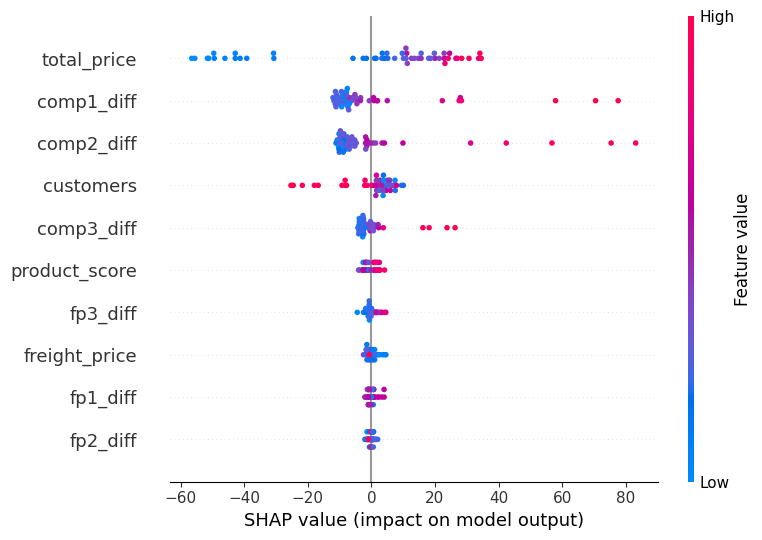

In [18]:
explainer = shap.Explainer(model, X)
shap_values = explainer(X)

# Plot the SHAP values for each feature
shap.summary_plot(shap_values, X)

In [20]:
products['unit_price_pred'] = y_pred
products['error'] = abs(products['unit_price'] - products['unit_price_pred'])
products.head()

,product_id,total_price,freight_price,customers,comp1_diff,comp2_diff,comp3_diff,fp1_diff,fp2_diff,fp3_diff,product_score,unit_price,unit_price_pred,error
0,bed1,5831.77,240.410762,915,-43.976523,-47.634907,0.000000,-2.629416,-1.484667,0.000000,4.0,42.211989,42.489737,0.277748
1,bed2,42938.66,324.204152,968,0.000000,-28.547817,37.032861,0.000000,-0.989857,2.214245,3.9,86.774536,103.087462,16.312926
2,bed3,10304.96,172.316049,530,7.599892,0.000000,51.588471,-2.996105,0.000000,0.378738,3.3,92.101364,98.837131,6.735767
3,bed4,6011.77,151.576305,515,-38.826174,0.000000,6.085263,-3.644118,0.000000,-0.023987,4.2,46.725444,44.375751,2.349694
4,bed5,29997.36,96.015504,385,108.481703,0.000000,152.431703,3.761456,0.000000,4.750934,4.4,198.381703,185.783795,12.597908


In [56]:
products.sort_values(by='unit_price_pred')

,product_id,total_price,freight_price,customers,comp1_diff,comp2_diff,comp3_diff,fp1_diff,fp2_diff,fp3_diff,product_score,unit_price,unit_price_pred,error
12,consoles2,2384.00,137.285194,221,-0.149048,0.000000,0.000000,-0.815574,0.000000,0.000000,3.9,25.584286,29.505098,3.920813
36,health4,4096.30,115.849527,1373,5.372727,-55.233766,-29.090000,-2.736110,-5.049822,-4.968138,4.5,29.900000,31.587471,1.687471
11,consoles1,3416.70,188.521934,218,0.000000,0.124206,0.000000,0.000000,0.679645,0.000000,4.2,28.241667,31.880883,3.639217
41,health9,6325.19,248.514607,1648,0.000000,-57.176335,-37.703821,0.000000,-1.164592,-1.780786,4.3,22.623745,34.917869,12.294124
20,furniture3,3507.95,176.088957,626,-36.721814,-0.189426,-46.480537,-0.776198,0.173284,-6.055285,3.8,36.705574,35.890252,0.815323
18,furniture1,6162.11,188.012554,613,-37.945282,0.000000,-41.348388,-2.310799,0.000000,-5.757427,3.7,36.749231,39.004585,2.255354
15,cool3,3656.50,145.241285,182,-37.261905,-41.495714,0.000000,-1.966602,-1.679459,0.000000,4.4,42.000000,40.545275,1.454725
0,bed1,5831.77,240.410762,915,-43.976523,-47.634907,0.000000,-2.629416,-1.484667,0.000000,4.0,42.211989,42.489737,0.277748
3,bed4,6011.77,151.576305,515,-38.826174,0.000000,6.085263,-3.644118,0.000000,-0.023987,4.2,46.725444,44.375751,2.349694
29,garden7,6220.90,292.271929,1806,0.069546,-0.067675,-0.021922,0.713575,-2.235134,-0.154607,4.2,54.962500,45.780083,9.182417


In [55]:
products.describe()

,total_price,freight_price,customers,comp1_diff,comp2_diff,comp3_diff,fp1_diff,fp2_diff,fp3_diff,product_score,unit_price,unit_price_pred,error
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,18495.213462,268.869509,1053.365385,25.694650,11.373008,21.978372,1.386296,1.745994,2.496575,4.080769,106.470073,105.824600,10.038151
std,13835.432740,154.777349,537.660912,67.764948,59.018322,66.786669,9.965577,6.877787,6.846434,0.251301,72.902890,65.983321,9.008672
min,2384.000000,83.146419,182.000000,-46.368308,-59.325427,-98.710989,-27.774975,-10.198447,-6.055285,3.300000,22.623745,29.505098,0.277748
25%,9160.215000,176.618953,595.250000,-0.200079,-19.909887,-0.039309,-0.786042,-1.485233,-1.040041,3.900000,54.888369,56.810542,2.913045
50%,14680.585000,228.625875,994.500000,0.120879,0.000000,0.022877,1.337385,0.000000,0.000000,4.100000,92.291756,98.987352,7.604173
75%,22956.172500,284.091531,1589.250000,44.036786,31.639515,32.167527,3.866475,1.441065,3.158166,4.225000,134.791854,130.521414,13.410095
max,63885.000000,731.001186,1839.000000,295.392948,241.110879,290.250509,24.637490,23.306815,21.236853,4.500000,350.744318,334.354741,42.575515


In [30]:
products[products['product_id'] == 'bed1'].sort_values(by='unit_price')

,product_id,total_price,freight_price,customers,comp1_diff,comp2_diff,comp3_diff,fp1_diff,fp2_diff,fp3_diff,product_score,unit_price,unit_price_pred,error
0,bed1,5831.77,240.410762,915,-43.976523,-47.634907,0.0,-2.629416,-1.484667,0.0,4.0,42.211989,42.489737,0.277748


In [21]:
largest_error = products[products['error'] == max(products['error'])].drop(['product_id'], axis=1)
smallest_error = products[products['error'] == min(products['error'])].drop(['product_id'], axis=1)

In [25]:
data_for_prediction = largest_error 
print("-------------------- LARGEST ERROR PREDICTION --------------------\n\n")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

-------------------- LARGEST ERROR PREDICTION --------------------




In [23]:
data_for_prediction = smallest_error
print("-------------------- SMALLEST ERROR PREDICTION --------------------\n\n")
explainer = shap.TreeExplainer(model)
shap_values = explainer.shap_values(data_for_prediction)
shap.initjs()
shap.force_plot(explainer.expected_value[0], shap_values[0], data_for_prediction)

-------------------- SMALLEST ERROR PREDICTION --------------------


